# Problem 1


In [1]:
import string
import math

class VigenereSolver:
    """A collection of methods for performing a ciphertext-only attack on a
    Vigenere cipher
    """
    @classmethod
    def index_of_coincidence(cls, text: str) -> float:
        counts = dict()
        for c in text:
            counts[c] = counts.get(c, 0) + 1
        
        numerator = sum(
            [math.comb(counts.get(c, 0), 2) for c in string.ascii_uppercase])
        denominator = math.comb(len(text), 2)

        return numerator / denominator

    @classmethod
    def _block_align(cls, text: str, blocksize: int, offset: int) -> str:
        """Return a sub-ciphertext that is the offset'th byte of each block"""
        i = offset
        subtext = []
        while i < len(text):
            subtext.append(text[i])
            i += blocksize
        return "".join(subtext)

    @classmethod
    def _score_blocksize(cls, text: str, reference_ioc: float, blocksize: int) -> float:
        mse = 0
        for offset in range(blocksize):
            subtext = cls._block_align(text, blocksize, offset)
            subtext_ioc = cls.index_of_coincidence(subtext)
            mse += (reference_ioc - subtext_ioc) ** 2
        return mse / blocksize

    @classmethod
    def search_blocksizes(cls, text: str, reference_ioc: float, max_blocksize: int) -> list[tuple[int, float]]:
        blocksizes = []

        for blocksize in range(1, max_blocksize + 1):
            score = cls._score_blocksize(text, reference_ioc, blocksize)
            blocksizes.append((blocksize, score))
        
        blocksizes.sort(key=lambda x: x[1])
        return blocksizes

if __name__ == "__main__":
    with open("inputs/q1-mobydick.txt") as f:
        text = f.read()
        reference_ioc = VigenereSolver.index_of_coincidence(text)
        print(f"Moby Dick's index of coincidence {reference_ioc}")
    
    with open("inputs/q1-ciphertext.txt") as f:
        ciphertext = f.read()
    blocksizes = VigenereSolver.search_blocksizes(ciphertext, reference_ioc, 100)
    for blocksize, score in blocksizes[:10]:
        print(f"Score of blocksize {blocksize}:\t{score:.6f}")

Moby Dick's index of coincidence 0.06592077212956918
Score of blocksize 21:	0.000007
Score of blocksize 42:	0.000013
Score of blocksize 63:	0.000022
Score of blocksize 84:	0.000026
Score of blocksize 28:	0.000380
Score of blocksize 7:	0.000381
Score of blocksize 14:	0.000382
Score of blocksize 56:	0.000386
Score of blocksize 77:	0.000389
Score of blocksize 35:	0.000390


## a)
Note that the definition of this assignemnt is missing a constant factor 26 (size of the English alphabet), which is okay since we are exclusively working with the English alphabet (instead of with, say, the German alphabet and the French alphabet as well). Without the constant factor, the index of coincidence is 0.06592; with the constant factor, the index of coincidence is 1.7139, which closely matches with the reference IoC (1.73) listed on [Wikipedia](https://en.wikipedia.org/wiki/Index_of_coincidence).

## b)
Using the code below, we can rank all possible blocksizes by some kind of metrics that measure the average distance between sub-ciphertext IoC and the reference IoC. In this implementation, I choose to use mean-square-error (mean of square of difference between IoC's). For my input, the top candidates are listed above in the code block.

Notice that the first four candidates are multiples of the top candidate, which makes sense since we can simply concatenate keys without affecting the encrpytion scheme. I think this is strong evidence that **21** is the correct key size.

## c)
The approach in part (b) relies on the assumption that the same character at the same offset in each plaintext block is always encrypted to the same character in the ciphertext (e.g. if an at offset of one plaintext block is encrypted to , then any at offset of all plaintext blocks is encrypted to ). However, this assumption is not true for the transposition cipher, where the corresponding ciphertext character of a block depends on the content of the rest of the block. Therefore, computing index of coincidence using aligned ciphertext blocks is not an effective approach to identify the blocksize of a transposition cipher.

<p style="page-break-after:always;"></p>

# Problem 2
UW user id `g66xu`

The single character frequencies of each ciphertext, as well as a reference single-character frequencies, are generated using the code below

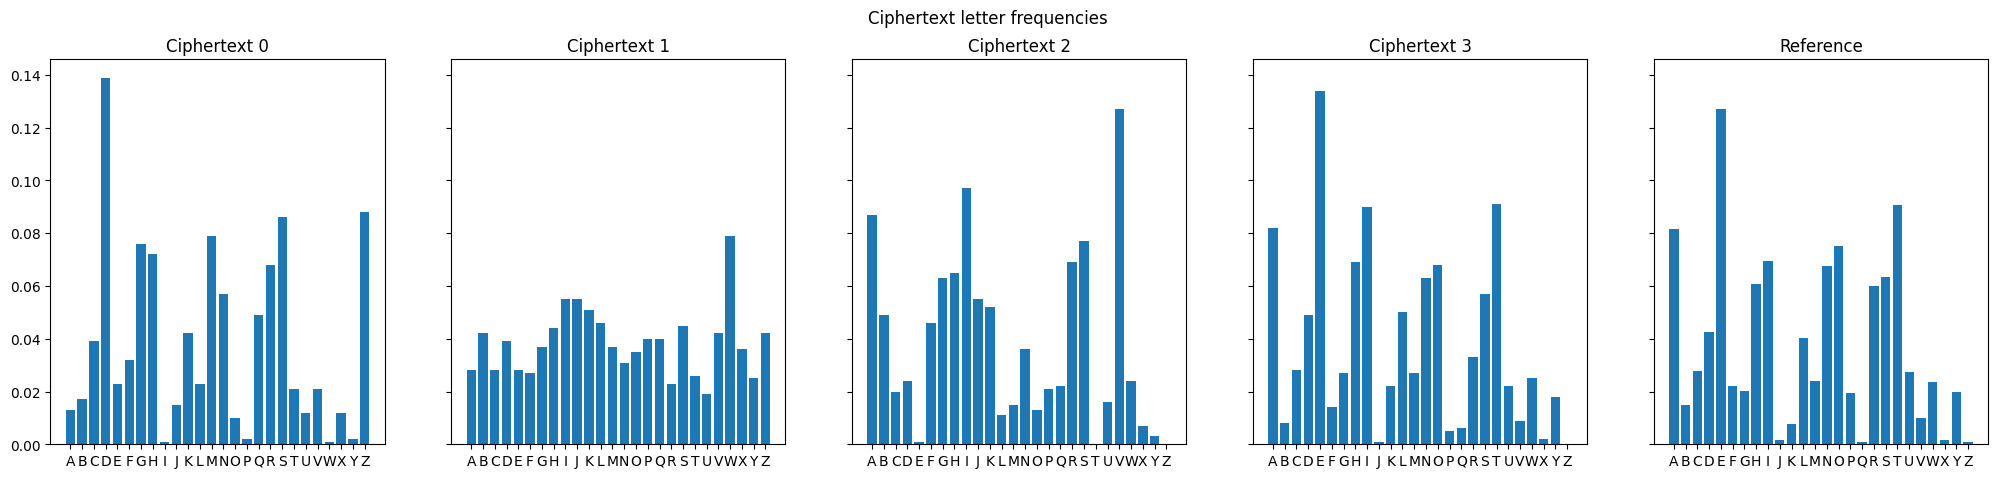

In [2]:
import string
import matplotlib.pyplot as plt

# credit: https://pi.math.cornell.edu/~mec/2003-2004/cryptography/subs/frequencies.html
REF_FREQUENCIES = [
    0.08167, 0.01492, 0.02782, 0.04253, 0.12702, 0.02228, 0.02015, 0.06094, 
    0.06966, 0.00153, 0.00772, 0.04025, 0.02406, 0.06749, 0.07507, 0.01929, 
    0.00095, 0.05987, 0.06327, 0.09056, 0.02758, 0.00978, 0.02360, 0.00150, 
    0.01974, 0.00074,
];

def char_frequencies(ciphertext_str: str) -> dict[str, float]:
    """Return a dictionary that maps individual characters to percentage
    frequencies
    """
    frequencies = {}
    for char in ciphertext_str:
        frequencies[char] = frequencies.get(char, 0) + 1
    
    for char in string.ascii_uppercase:
        frequencies[char] = frequencies.get(char, 0) / len(ciphertext_str)
    
    return frequencies

fig, subplots = plt.subplots(1, 5, sharex=True, sharey=True)
fig.suptitle("Ciphertext letter frequencies")
fig.set_size_inches(25, 5)

for ct_index in range(0, 4):
    path = f"inputs/a1q2ciphertexts/ctxt{ct_index}.txt"
    subplot = subplots[ct_index]
    with open(path) as f:
        ciphertext_str = f.read()
        frequencies = char_frequencies(ciphertext_str)
        subplot.bar(
            x=[char for char in string.ascii_uppercase],
            height=[frequencies.get(char) for char in string.ascii_uppercase]
        )
        subplot.set_title(f"Ciphertext {ct_index}")

subplot = subplots[4]  # the reference plot
subplot.bar([char for char in string.ascii_uppercase], REF_FREQUENCIES)
subplot.set_title(f"Reference")

plt.show()

## a)
Let's start with the **reference frequencies**. The reference frequency reveals some quirks of the English language: letters like E, T, and A are very frequently used, and letters like J, X, and Z are very infreuqently used. The distribution of percentage frequency follows a specific "shape" that can later be used to identify pattern in the ciphertext.

The **transposition cipher** preserves the character set of the plaintext. Therefore, if the plaintext follows the single character frequencies of the English language, then the ciphertext will have the exact same single character frequencies.

The **shift cipher** somewhat preserves the character set of the plaintext. In particular, it preserves the ordering of the characters. For example, in the English alphabet the letter that follows "A" is "B", so the ciphertext letter of "B" will be an English alphabet letter that immediately follows the ciphertext letter of "A" (of course we will set the letter that follows "Z" to be "A" to make the whole procedure well-defined)

The **substitution cipher** does not preserve the ordering of the letters, but because it always encrypts the same plaintext letter to the same ciphertext letter, the single character frequencies will still exhibit a comparatively (especially compared to ciphers that distribute the ciphertext characters more evenly) wide distribution of frequencies.

The **Vigenere cipher** does not preserve the single letter frequencies at all, since it does not always encrypts the same plaintext letter to the same ciphertext letter. It should exhibit a comparatively more uniform distribution of ciphertext letters

## b)
The single letter frequencies of the **transposition cipher** should look exactly the same as the reference frequency because all plaintext letters are entirely preserved. Therefore, ciphertext 3 is encrypted using the transposition cipher.

The single letter frequencies of the **shift cipher** should look like the reference frequency, but entirely shifted left or right by a few characters. Therefore, ciphertext 0 is encrypted using the shift cipher. In fact, we can visually identify that the key of the shift cipher is $25 \mod 26$ since the entire graph is shifted left by one letter.

Of the remaining two frequencies, we can see that one of them is substantially more uniform than the other. From that we can deduce that ciphertext 1 is encrypted using the Vigenere cipher, and that ciphertext 2 is encrypted using the substitution cipher.

## c)

### Cryptanalysis on transposition cipher
Unfortunately because the transposition cipher entirely preserves the single character frequencies, the histogram will not be effective in the cryptanalysis of this cipher.

Knowing that the block size of the transposition cipher is between 6 and 13, we can simply brute-force all possible permutations (we can narrow down the search space a little bit by observing that all size-6 permutation is also a size-12 permutation, so we actually only need to search through all possible permutations of size between 7 and 13). $\sum_{n=7}^{13}n! = 6749976960 \approx 6.75e9$, which is very doable with a modern computer.

We can also try to identify the block size by finding repeating ciphertext blocks. This is effective because a transposition cipher always encrypts the same plaintext block to the same ciphertext block. Of course, for small permutation sizes, repeating n-grams will be trivially common, so this technique should be reserved for sufficiently large block sizes (which would be handy since large block size also means large key space, so being able to narrow down the block size ranges for large block sizes is helpful).

The tricky part is identifying valid plaintext, for which frequency analysis would be ineffective since all plaintexts will have identify frequencies. Instead, we might need to lean on some kind of "list of common English words" ("the" for example should be a prime target). For each of the plaintext produced by one of candidate key, we search through the list of common words and count the number of times they show up in the candidate plaintext. Finally, we can rank the keys by "occurrences of common words", with keys having the highest occurrences of common words being the most likely candidate.

### Cryptanalysis on shift cipher
By the very nature of a "alphabetic" language, the key space of any shift cipher will be very small, so it is trivially easy to brute-force through all possible keys and examine each candidate plaintext.

In addition, we can also observe the relative shape of the single character frequencies and visually identify the direction and distance by which the histogram has been shifted.

### Cryptanalysis on substitution cipher
Because the substitution cipher always encrypts the same plaintext letter to the same ciphertext letter, the ciphertext of the most frequent plaintext letter is also the most frequent ciphertext letter, and the ciphertext of the second most frequent plaintext letter is the second most frequent ciphertext letter, so on and so forth. Assuming that the plaintext follows some single letter frequencies that are similar to the reference frequency, we can make good guesses on the key by assuming that the most frequent plaintext letter is substituted with the most frequent ciphertext letter, etc.

Also, note that $\log_2 26! \approx 88$, so we can also rent some big server on AWS and just brute force all possible keys.

### Cryptanalysis on Vigenere cipher
We can identify the block size of the cipher using the index of coincidence, as described in question 1.

After identifying the block size, we can solve the key of the cipher letter by letter. To solve `key[i]`, we take all letters at position `i` of each block (so the letter at index `i, i+blocksize, i+2*blocksize, ...`) and assemble them into a sub-ciphertext:

```python
# Assembling the sub-ciphertext for key[i]
sub_ciphertext = [ciphertext[j] for j in range(i, len(ciphertext), blocksize)]
```

Notice that the sub-ciphertext is essentially encrypted using a shift cipher, which we've shown to be easily broken by comparing the single letter frequencies against the reference frequencies.

## d) Solve shift cipher, substitution cipher, and Vigenere cipher

In [3]:
# Some convenient implementations

class CaesarCipher:
    def __init__(self, key: str):
        """The key is such that it maps the plaintext letter at ALPHABET[i] into
        a plaintext letter at ALPHABET[key[i]]
        """
        if len(key) != len(string.ascii_uppercase):
            raise Exception("Invalid key length")
        if set(key) != set(string.ascii_uppercase):
            raise Exception("Invalid key mapping")
        self.key = key
    
    def encrypt(self, plaintext: str) -> str:
        return "".join([self.key[string.ascii_uppercase.index(c)] for c in plaintext])
    
    def decrypt(self, ciphertext: str) -> str:
        return "".join([string.ascii_uppercase[self.key.index(c)] for c in ciphertext])

class VigenereCipher:
    def __init__(self, key: str):
        """The key is a string containing alphabetic letters with identical
        encoding as the built-in alphabet
        """
        for c in key:
            if c not in string.ascii_uppercase:
                raise Exception(f"Invalid key character {c}")
        self.key = key
    
    def encrypt(self, plaintext: str) -> str:
        ciphertext = ""
        for i, pt_char in enumerate(plaintext):
            key_char = self.key[i % len(self.key)]
            pt_char_code = string.ascii_uppercase.index(pt_char)
            key_char_code = string.ascii_uppercase.index(key_char)
            ct_char_code = (pt_char_code + key_char_code) % len(string.ascii_uppercase)
            ct_char = string.ascii_uppercase[ct_char_code]
            ciphertext += ct_char
        return ciphertext

    def decrypt(self, ciphertext: str) -> str:
        plaintext = ""
        for i, ct_char in enumerate(ciphertext):
            key_char = self.key[i % len(self.key)]
            ct_char_code = string.ascii_uppercase.index(ct_char)
            key_char_code = string.ascii_uppercase.index(key_char)
            pt_char_code = (ct_char_code - key_char_code + len(string.ascii_uppercase)) % len(string.ascii_uppercase)
            pt_char = string.ascii_uppercase[pt_char_code]
            plaintext += pt_char
        return plaintext

First, the shift cipher (ciphertext 0) can be trivially solved with visual inspection of the single character frequencies.

> WHITE KID GLOVES IN ONE HAND AND A LARGE FAN IN THE OTHER HE CAME TROTTING ALONG IN A GREAT HURRY

In [4]:
with open("inputs/a1q2ciphertexts/ctxt0.txt") as f:
    ct_0 = f.read()

cipher = VigenereCipher("Z")
print(cipher.decrypt(ct_0)[:80])

WHITEKIDGLOVESINONEHANDANDALARGEFANINTHEOTHERHECAMETROTTINGALONGINAGREATHURRYMUT


Frequency analysis will be a common thread across Vigenere cipher and Caesar cipher, but unfortunately the ordering can be rather fluid, and it's a lot of work to write code that automate this fluidity, so I resorted to using [this online tool](https://www.guballa.de/substitution-solver) and [this online tool](https://www.guballa.de/vigenere-solver) to perform the frequency analysis. However, I will use index of coincidence to nail down the key size for the Vigenere cipher:

In [5]:
with open("inputs/a1q2ciphertexts/ctxt1.txt") as f:
    ct_1 = f.read()

for blocksize, score in VigenereSolver.search_blocksizes(ct_1, 1.73 / 26, 13)[:5]:
    print(f"blocksize: {blocksize:6d}, score: {score:.6f}")

blocksize:      8, score: 0.000073
blocksize:      4, score: 0.000104
blocksize:     12, score: 0.000144
blocksize:     10, score: 0.000371
blocksize:      2, score: 0.000383


Using the online tools listed above:

Plaintext for ciphertext 1:

> REPLY IT HAD LEFT OFF SNEEZING BY THIS TIME DONT GRUNTS AID ALICE THATS NOT...

Plaintext for ciphertext 2

> TELY WAS JUST IN TIME TO SEE IT POP DOWN A LARGE RABBIT HOLE UNDER THE...

In [6]:
key_1 = "dvowsfie".upper()
print(VigenereCipher(key_1).decrypt(ct_1)[:80])

with open("inputs/a1q2ciphertexts/ctxt2.txt") as f:
    ct_2 = f.read()
key_2 = "odmfxrshtlicywkgunaqbepvjz".upper()
print(CaesarCipher(key_2).encrypt(ct_2)[:80])

REPLYITHADLEFTOFFSNEEZINGBYTHISTIMEDONTGRUNTSAIDALICETHATSNOTATALLAPROPERWAYOFEX
TELYWASJUSTINTIMETOSEEITPOPDOWNALARGERABBITHOLEUNDERTHEHEDGEINANOTHERMOMENTDOWNW


<p style="page-break-after:always;"></p>

# Problem 3
UW user id `g66xu`

## a)
Given that the stream cipher uses a PRG to generate a byte stream (the key stream) that is directly XOR'd with the plaintext byte stream to produce the ciphertext, we can recover the key stream by computing $\text{PT} \oplus \text{CT}$. For small key stream this can be done by hand:

$$
\begin{aligned}
        &0011110010110101 \\
\oplus\;&0001111101100011 \\
\text{key stream}\;=\;&0010001111010110
\end{aligned}
$$

## b)
For a 4-stage LFSR, the initial state of the register is the first four bits of the key stream:

$$
\begin{aligned}
s_0 &= 0 \\
s_1 &= 0 \\
s_2 &= 1 \\
s_3 &= 0 \\
\end{aligned}
$$

## c)
Plug in $i \in \{0, 1, 2, 3\}$ for the LFSR circuit: $s_{i+4} = \sum_{j=0}^3c_j \cdot s_{i+j}$ we have the following set of equations:

$$
\begin{aligned}
s_4 &= c_0s_0 + c_1s_1 + c_2s_2 + c_3s_3 \\
s_5 &= c_0s_1 + c_1s_2 + c_2s_3 + c_3s_4 \\
s_6 &= c_0s_2 + c_1s_3 + c_2s_4 + c_3s_5 \\
s_7 &= c_0s_3 + c_1s_4 + c_2s_5 + c_3s_6 \\
\end{aligned}
$$

Which corresponds to the following matrix multiplication:

$$
\begin{bmatrix}
s_0 & s_1 & s_2 & s_3 \\
s_1 & s_2 & s_3 & s_4 \\
s_2 & s_3 & s_4 & s_5 \\
s_3 & s_4 & s_5 & s_6 \\
\end{bmatrix}
\cdot
\begin{bmatrix}
c_0 \\ c_1 \\ c_2 \\ c_3
\end{bmatrix}
=
\begin{bmatrix}
s_4 \\ s_5 \\ s_6 \\ s_7
\end{bmatrix}
$$

Plug in the value for $s_i$ we have:

$$
\begin{bmatrix}0&0&1&0 \\ 0&1&0&0 \\ 1&0&0&0 \\ 0&0&0&1 \end{bmatrix}
\cdot
\begin{bmatrix}c_0 \\ c_1 \\ c_2 \\ c_3\end{bmatrix}
=
\begin{bmatrix} 0 \\ 0 \\ 1 \\ 1 \end{bmatrix}
$$

## d)

Re-arranging the rows of the matrix multiplication above is sufficient to transform it into a unit matrix:

$$
\begin{bmatrix}1&0&0&0 \\ 0&1&0&0 \\ 0&0&1&0 \\ 0&0&0&1 \end{bmatrix}
\cdot
\begin{bmatrix}c_0 \\ c_1 \\ c_2 \\ c_3\end{bmatrix}
=
\begin{bmatrix}1 \\ 0 \\ 0 \\ 1 \end{bmatrix}
$$

From here it is trivial to conclude that $c_0 = 1, c_1 = 0, c_2 = 0, c_3 = 1$

## e)
![stuff](./static/a1q3.png)

<p style="page-break-after:always;"></p>

# Problem 4

## a)
From the key we know the block size to be 2, so the message is encoded into $\mathbb{Z}_{26}^{3 \times 2}$:

$$
\text{Encode}(\text{COOKIE}) = \begin{bmatrix} 2 & 14 \\ 14 & 10 \\ 8 & 4 \end{bmatrix}
$$

The matrix multiplication is small enough to be done by hand:

$$
\begin{aligned}
\text{E}(K, M) &= MK \mod 26 \\
&= \begin{bmatrix} 2 & 14 \\ 14 & 10 \\ 8 & 4 \end{bmatrix} \cdot \begin{bmatrix} 13 & 16 \\ 8 & 23 \end{bmatrix} \mod 26 \\
&= \begin{bmatrix} 8 & 16 \\ 2 & 12 \\ 6 & 12 \end{bmatrix} \\
&= \text{Encode}(\text{IQCMGM}) \\
\end{aligned}
$$

## b)
Knowing $M$ and $C=MK$, we can try to compute $K$ via $K = M^{-1}C = M^{-1}MK = K$. For this procedure to work we need to make sure that the encoding of the plaintext is an invertible matrix, so there needs to be as many blocks as the block length, and the row vectors need to be linearly independent. While it is technically ok to have more blocks than key length, and the system is guaranteed to be solvable (but not unique!) since the ciphertext is generated from the plaintext, in practice I think we will simply take the first $l$ linearly independent row vectors to form $M$.

Of course, if we can mount a chosen plaintext attack, then we can choose $M$ to be some unit matrix and make the whole thing trivially broken.

## c)
By the specificiation of the cipher we know that the ciphertext length must be a multiple of the block length, so we can iterate through all possible factors of the ciphertext length. For each possible block length $l$, we try to encode the plaintext and pick the first $l$ linearly independent row vectors to form $M$ and then compute $M^{-1}C$ to recover the key; if an invertible $M$ is impossible, then we move on to the next possible block length, until a valid key is found.

Again, to make sure that there can be an invertible $M$, there needs to be at least as many blocks as the (candidate) block length

## d)
For $l = 2$, the key space is computationally small $\vert \mathcal{K} \vert < 26^{2 \times 2} < 2^{19}$ (less than $26^4$ beceause not all matrices are invertible), so we can mount an exhaustive search. The only obstacle is to rank the keys based on the quality of the plaintext (how much the plaintext resembles meaningful English).

For each of the candidate plaintext, we can search through all possible digrams and build an ordered list of most common digrams in the candidate plaintext. Then we can compare this ranked list againt the reference ranked list of common digrams and check how many of the most common digrams in the candidate plaintext are also the most common digrams in English. The candidate plaintext with the highest number of intersection with common English digrams is thus the most likely decryption, and the associated candidate key is the most likely key.

<p style="page-break-after:always;"></p>

# Problem 5

## a)
We denote fixed-size bit blocks using a vector in $\mathbb{Z}_2^l$ where $l$ is the block size and/or the key size (in this case they are equal).

We claim without proof (but an example will be given) that permutation can be represented by a left matrix multiplication $A \in \mathbb{Z}_2^{l \times l}$ where $l in \mathbb{Z}$ is the block size. Here is one such multiplication (though not the only one) that permutes `[1, 0, 1, 0]` to `[0, 0, 1, 1]`:

$$
\begin{bmatrix} 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 1 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 \end{bmatrix}
\begin{bmatrix} 1 \\ 0 \\ 1 \\ 0 \end{bmatrix}
= \begin{bmatrix} 0 \\ 0 \\ 1 \\ 1 \end{bmatrix}
$$

We will further claim that the permutation matrix $A$ is a row (or column) permutation of the identity matrix $I \in \mathbb{Z}_2^{l \times l}$.

Denote the vector of all 1's by $\vec{1} \in \mathbb{Z}_2^l$. We can observe that in mod 2 arithmetics, negation is equivalent to adding the $\vec{1}$ vector because $0 + 1 = 1 = \text{NOT}(0)$ and $1 + 1 = 0 = \text{NOT}(1)$. Observe that multiplying a permutation matrix by $\vec{1}$ returns $\vec{1}$ since permutation of a bunch of 1's is still a bunch of 1's.

$$
\text{Bitwise-NOT}(\vec{m}) = \vec{m} + \vec{1} \; \mod 2
$$

Finally, we claim that bitwise XOR is equivalent to addition mod 2.

Suppose the permutation matrix to be $U$, then each round of the NVS network can be described follows:

$$
F_i(\vec{m}) = U(\vec{m} + \vec{k}_i + \vec{1})
$$

We can then describe the encryption scheme as a composition of the round functions. Since each round function is a linear transformation (scale and add some constant), the composition is also a linear transformation, and the coefficient on $\vec{m}$ is actually just some power of $U$:

$$
E(k, \vec{m}) = (F_{16} \circ F_{15} \circ \ldots \circ F_{1})(m) = U^{16}\vec{m} + C(k_1, k_2, \ldots, k_{16})
$$

where $C(k_1, k_2, \ldots, k_{16})$ is a constant term that involves the 16 rounds keys. Since $U$ is known, $U^{16}$ can also be efficiently computed.

If an adversary has access to a single plaintext/cipehrtext pair, the adversary will be able to solve for the constant term (without needing to know the round keys or the master key). From there, both the encryption and the decryption schemes become known, and the adversary can encrypt arbitrary plaintext and decrypt arbitrary ciphertext.

## b)
From the linear relationship developed above it's also fairly simple to deduce that the encryption scheme is also linear with respect to each of the round key, this means that with a minimum of 16 pairs of carefully chosen plaintext/ciphertext pairs, we should be able to solve for the 16 rounds keys.

Whether we can recover the master key from the rounds keys depends on the key expansion function, which is not described in this question (say if we have a sufficiently secure PRG for key expansion, then breaking the master key would mean breaking the PRG, which is obviously not practical), although it is not hard to see that in practice, being able to recover the round keys is as good as recovering the master key.

## c)
Adding the number of rounds will not alter the fact that the encryption scheme is still a linear relationship with respect to the plaintext, only changing the value for coefficient and constant term, so the attack described in part (a) is still valid.

## d)
Similar to part (c), operating on larger blocks and/or with larger keys does not change the fact that the encryption scheme is still a linear relationship (inverting a matrix takes polynomial time, too, so the computing the inverse of $U^e$ can also be efficiently done), so the attack in part (a) is still valid.